# Snake

In [24]:
import environments_fully_observable 
import environments_partially_observable
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

# GPU configuration
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Environment definition

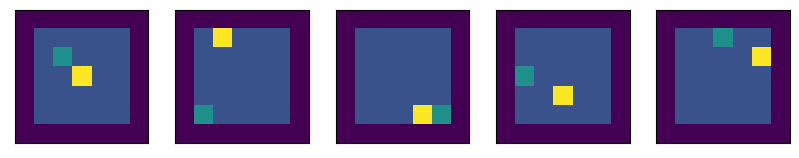

In [25]:
%matplotlib inline
# function to standardize getting an env for the whole notebook
def get_env(n=1000):
    # n is the number of boards that you want to simulate parallely
    # size is the size of each board, also considering the borders
    # mask for the partially observable, is the size of the local neighborhood
    size = 7
    e = environments_fully_observable.OriginalSnakeEnvironment(n, size)
    # or environments_partially_observable.OriginalSnakeEnvironment(n, size, 2)
    return e
env_ = get_env()
GAMMA = .9
ITERATIONS = 5000

fig,axs=plt.subplots(1,min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")

## Model

In [ ]:
# define the models that you need ()
from collections import deque

class DQN(tf.keras.Model):
    def __init__(self, input_dim, n_actions):
        super(DQN, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_dim)
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(256, activation='relu')
        self.out = tf.keras.layers.Dense(n_actions, activation=None)

    def call(self, x):
        x = tf.cast(x, tf.float32)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return self.out(x)

class ReplayBuffer:
    def __init__(self, size=10000):
        self.buffer = deque(maxlen=size)        

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        if len(self.buffer) < batch_size:
            batch_size = len(self.buffer)
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones)
        )
    
    def __len__(self):
        return len(self.buffer)
    
class DQNAgent:
    def __init__(self, state_shape, n_actions=4, buffer_size=10000, batch_size=32, epsilon_start=1., epsilon_end=0.1, epsilon_decay=0.9995, learning_rate=1e-4, gamma=0.9, target_update_freq=100):
        self.state_shape = state_shape
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.lr = learning_rate
        self.target_update_freq = target_update_freq
        self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=self.lr)
        self.step_counter = 0

        self.qnet = DQN(state_shape, n_actions)
        self.target_network = DQN(state_shape, n_actions)

        # Initialization with a forward pass
        dummy_state = np.zeros((1,) + state_shape)
        self.qnet(dummy_state)
        self.target_network(dummy_state)

        self.update_target_network()
        self.replay_buffer = ReplayBuffer(buffer_size)

    def update_target_network(self):
        """ Copy weights from main Q-network to target network """
        self.target_network.set_weights(self.qnet.get_weights())

    def select_action(self, state):
        """ Select action using epsilon-greedy policy """
        batch_size = state.shape[0]
        if np.random.random() < self.epsilon:
            actions = np.random.randint(0, self.n_actions, size=(batch_size, 1))
        else:
            q_values = self.qnet(state)
            actions = tf.argmax(q_values, axis=1, output_type=tf.int32)
            actions = tf.reshape(actions, [-1, 1])
            actions = actions.numpy()

        return actions
    
    def store_experience(self, state, action, reward, next_state, done):
        """ Store experience in replay buffer """
        for i in range(state.shape[0]):
            self.replay_buffer.add((
                state[i].numpy(),
                action[i][0],
                reward[i].numpy()[0],
                next_state[i].numpy(),
                done[i].numpy()
            ))
        
    def train(self, state, action, reward, next_state, done):
        """ Store experience and train the Q-network """

        self.store_experience(state, action, reward, next_state, done)

        if len(self.replay_buffer) < self.batch_size:
            return 0.0
        
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.int32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.bool)

        with tf.GradientTape() as tape:
            q_values = self.qnet(states)
            action_mask = tf.one_hot(actions, self.n_actions)
            q_values_for_actions = tf.reduce_sum(q_values * action_mask, axis=1)

            next_q_values = self.target_network(next_states)
            max_next_q = tf.reduce_max(next_q_values, axis=1)
            dones = tf.cast(dones, tf.float32)

            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q

            # Loss            
            loss = tf.keras.losses.MSE(target_q_values, q_values_for_actions)

        gradients = tape.gradient(loss, self.qnet.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.qnet.trainable_variables))

        self.step_counter += 1
        if self.step_counter % self.target_update_freq == 0:
            self.update_target_network()

        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

        return loss.numpy()
    
    def get_q_values(self, state):
        """ Get Q-values for a given state """
        return self.qnet(state)
    
    def save_weights(self, filepath="snake_dqn_weights.h5"):
        """ Save the model weights """
        self.qnet.save_weights(filepath)
        print(f"Model weights saved to {filepath}")

    def load_weights(self, filepath="snake_dqn_weights.h5"):
        if not os.path.exists(filepath):
            raise ValueError(f"File {filepath} does not exist.")
        self.qnet.load_weights(filepath)
        self.update_target_network()
        print(f"Model weights loaded from {filepath}")

        
agent = DQNAgent(state_shape=env_.to_state().shape[1:], gamma=GAMMA, n_actions=4, epsilon_start=1., epsilon_end=0.05, epsilon_decay=0.9995, learning_rate=1e-4, target_update_freq=100)
value = ...
q = ...

## Training

In [17]:
optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

In [ ]:
rewards_history = []
loss_history = []
max_fruits_eaten = 0

for iteration in trange(ITERATIONS):
    # get current state of the boards
    state = tf.constant(env_.to_state())

    with tf.GradientTape(persistent=True) as tape:
        """ 
        tensor of actions, consider that
            UP = 0
            RIGHT = 1
            DOWN = 2
            LEFT = 3
        """
        # state = tf.constant(env_.to_state())
        actions = agent.select_action(state)
        
        # actions = ... 
        rewards = env_.move(actions)
        new_state = tf.constant(env_.to_state())

        dones = rewards < -0.1
        # calculate the loss of whichever algorithm you have picked
        # loss = ...
        loss = agent.train(state, actions, rewards, new_state, dones)

        mean_reward = tf.reduce_mean(rewards).numpy()
        rewards_history.append(mean_reward)
        if loss is not None:
            loss_history.append(loss)

        if iteration % 100 == 0:
            avg_reward = np.mean(rewards_history[-100:]) if rewards_history else 0
            avg_loss = np.mean(loss_history[-100:]) if loss_history else 0
            epsilon = agent.epsilon

            fruits_eaten = tf.reduce_sum(tf.cast(rewards == 0.5, tf.int32)).numpy()
            max_fruits_eaten = max(max_fruits_eaten, fruits_eaten)
            print(f"Iteration {iteration}: Avg Reward: {avg_reward:.2f}, Avg Loss: {avg_loss:.4f}, Epsilon: {epsilon:.4f}")
            print(f"Fruits eaten: {fruits_eaten}, Max fruits eaten: {max_fruits_eaten}")

  0%|          | 1/5000 [00:01<2:44:44,  1.98s/it]

Iteration 0: Avg Reward: -0.01, Avg Loss: 0.0085, Epsilon: 0.9980
Fruits eaten: 23, Max fruits eaten: 23


  2%|▏         | 101/5000 [02:56<2:13:08,  1.63s/it]

Iteration 100: Avg Reward: -0.01, Avg Loss: 0.0081, Epsilon: 0.9493
Fruits eaten: 18, Max fruits eaten: 23


  4%|▍         | 201/5000 [06:01<2:37:44,  1.97s/it]

Iteration 200: Avg Reward: -0.01, Avg Loss: 0.0068, Epsilon: 0.9030
Fruits eaten: 20, Max fruits eaten: 23


  6%|▌         | 301/5000 [09:08<2:26:42,  1.87s/it]

Iteration 300: Avg Reward: -0.01, Avg Loss: 0.0071, Epsilon: 0.8590
Fruits eaten: 20, Max fruits eaten: 23


  8%|▊         | 401/5000 [12:12<2:23:27,  1.87s/it]

Iteration 400: Avg Reward: -0.01, Avg Loss: 0.0058, Epsilon: 0.8171
Fruits eaten: 17, Max fruits eaten: 23


 10%|█         | 501/5000 [15:14<2:14:37,  1.80s/it]

Iteration 500: Avg Reward: -0.01, Avg Loss: 0.0069, Epsilon: 0.7772
Fruits eaten: 21, Max fruits eaten: 23


 12%|█▏        | 601/5000 [18:16<2:11:21,  1.79s/it]

Iteration 600: Avg Reward: -0.01, Avg Loss: 0.0072, Epsilon: 0.7393
Fruits eaten: 26, Max fruits eaten: 26


 14%|█▍        | 701/5000 [21:18<2:08:45,  1.80s/it]

Iteration 700: Avg Reward: -0.00, Avg Loss: 0.0075, Epsilon: 0.7032
Fruits eaten: 26, Max fruits eaten: 26


 16%|█▌        | 801/5000 [24:20<2:09:24,  1.85s/it]

Iteration 800: Avg Reward: -0.00, Avg Loss: 0.0082, Epsilon: 0.6689
Fruits eaten: 30, Max fruits eaten: 30


 18%|█▊        | 901/5000 [27:23<2:03:52,  1.81s/it]

Iteration 900: Avg Reward: -0.00, Avg Loss: 0.0070, Epsilon: 0.6363
Fruits eaten: 44, Max fruits eaten: 44


 20%|██        | 1001/5000 [30:24<1:57:58,  1.77s/it]

Iteration 1000: Avg Reward: -0.00, Avg Loss: 0.0067, Epsilon: 0.6052
Fruits eaten: 63, Max fruits eaten: 63


 22%|██▏       | 1101/5000 [33:29<2:01:16,  1.87s/it]

Iteration 1100: Avg Reward: 0.00, Avg Loss: 0.0102, Epsilon: 0.5757
Fruits eaten: 84, Max fruits eaten: 84


 24%|██▍       | 1201/5000 [36:33<1:55:11,  1.82s/it]

Iteration 1200: Avg Reward: 0.00, Avg Loss: 0.0116, Epsilon: 0.5476
Fruits eaten: 32, Max fruits eaten: 84


 26%|██▌       | 1301/5000 [39:37<1:55:27,  1.87s/it]

Iteration 1300: Avg Reward: 0.00, Avg Loss: 0.0128, Epsilon: 0.5209
Fruits eaten: 25, Max fruits eaten: 84


 28%|██▊       | 1401/5000 [42:40<1:51:28,  1.86s/it]

Iteration 1400: Avg Reward: 0.01, Avg Loss: 0.0132, Epsilon: 0.4955
Fruits eaten: 27, Max fruits eaten: 84


 30%|███       | 1501/5000 [45:41<1:43:20,  1.77s/it]

Iteration 1500: Avg Reward: 0.01, Avg Loss: 0.0131, Epsilon: 0.4713
Fruits eaten: 85, Max fruits eaten: 85


 32%|███▏      | 1601/5000 [48:45<1:41:31,  1.79s/it]

Iteration 1600: Avg Reward: 0.02, Avg Loss: 0.0132, Epsilon: 0.4483
Fruits eaten: 114, Max fruits eaten: 114


 34%|███▍      | 1701/5000 [51:46<1:37:19,  1.77s/it]

Iteration 1700: Avg Reward: 0.01, Avg Loss: 0.0151, Epsilon: 0.4265
Fruits eaten: 60, Max fruits eaten: 114


 36%|███▌      | 1801/5000 [54:50<1:36:31,  1.81s/it]

Iteration 1800: Avg Reward: 0.02, Avg Loss: 0.0141, Epsilon: 0.4057
Fruits eaten: 130, Max fruits eaten: 130


 38%|███▊      | 1901/5000 [57:53<1:34:09,  1.82s/it]

Iteration 1900: Avg Reward: 0.02, Avg Loss: 0.0157, Epsilon: 0.3859
Fruits eaten: 89, Max fruits eaten: 130


 40%|████      | 2001/5000 [1:00:56<1:30:37,  1.81s/it]

Iteration 2000: Avg Reward: 0.03, Avg Loss: 0.0152, Epsilon: 0.3671
Fruits eaten: 45, Max fruits eaten: 130


 42%|████▏     | 2101/5000 [1:04:00<1:36:23,  2.00s/it]

Iteration 2100: Avg Reward: 0.04, Avg Loss: 0.0157, Epsilon: 0.3491
Fruits eaten: 120, Max fruits eaten: 130


 44%|████▍     | 2201/5000 [1:07:02<1:30:39,  1.94s/it]

Iteration 2200: Avg Reward: 0.04, Avg Loss: 0.0174, Epsilon: 0.3321
Fruits eaten: 247, Max fruits eaten: 247


 46%|████▌     | 2301/5000 [1:10:05<1:20:43,  1.79s/it]

Iteration 2300: Avg Reward: 0.04, Avg Loss: 0.0183, Epsilon: 0.3159
Fruits eaten: 243, Max fruits eaten: 247


 48%|████▊     | 2401/5000 [1:13:10<1:22:24,  1.90s/it]

Iteration 2400: Avg Reward: 0.06, Avg Loss: 0.0229, Epsilon: 0.3005
Fruits eaten: 222, Max fruits eaten: 247


 50%|█████     | 2501/5000 [1:16:13<1:16:34,  1.84s/it]

Iteration 2500: Avg Reward: 0.05, Avg Loss: 0.0276, Epsilon: 0.2858
Fruits eaten: 54, Max fruits eaten: 247


 52%|█████▏    | 2601/5000 [1:19:18<1:12:15,  1.81s/it]

Iteration 2600: Avg Reward: 0.06, Avg Loss: 0.0289, Epsilon: 0.2719
Fruits eaten: 27, Max fruits eaten: 247


 54%|█████▍    | 2701/5000 [1:22:22<1:09:38,  1.82s/it]

Iteration 2700: Avg Reward: 0.07, Avg Loss: 0.0277, Epsilon: 0.2586
Fruits eaten: 220, Max fruits eaten: 247


 56%|█████▌    | 2801/5000 [1:25:24<1:06:08,  1.80s/it]

Iteration 2800: Avg Reward: 0.06, Avg Loss: 0.0261, Epsilon: 0.2460
Fruits eaten: 238, Max fruits eaten: 247


 58%|█████▊    | 2901/5000 [1:28:29<1:03:37,  1.82s/it]

Iteration 2900: Avg Reward: 0.08, Avg Loss: 0.0284, Epsilon: 0.2340
Fruits eaten: 31, Max fruits eaten: 247


 60%|██████    | 3001/5000 [1:31:32<59:48,  1.79s/it]  

Iteration 3000: Avg Reward: 0.07, Avg Loss: 0.0327, Epsilon: 0.2226
Fruits eaten: 58, Max fruits eaten: 247


 62%|██████▏   | 3101/5000 [1:34:36<58:50,  1.86s/it]  

Iteration 3100: Avg Reward: 0.09, Avg Loss: 0.0339, Epsilon: 0.2117
Fruits eaten: 129, Max fruits eaten: 247


 64%|██████▍   | 3201/5000 [1:37:38<53:28,  1.78s/it]  

Iteration 3200: Avg Reward: 0.08, Avg Loss: 0.0427, Epsilon: 0.2014
Fruits eaten: 135, Max fruits eaten: 247


 66%|██████▌   | 3301/5000 [1:40:42<51:49,  1.83s/it]

Iteration 3300: Avg Reward: 0.08, Avg Loss: 0.0373, Epsilon: 0.1916
Fruits eaten: 265, Max fruits eaten: 265


 68%|██████▊   | 3401/5000 [1:43:46<48:35,  1.82s/it]

Iteration 3400: Avg Reward: 0.08, Avg Loss: 0.0369, Epsilon: 0.1822
Fruits eaten: 52, Max fruits eaten: 265


 70%|███████   | 3501/5000 [1:46:51<45:53,  1.84s/it]

Iteration 3500: Avg Reward: 0.08, Avg Loss: 0.0390, Epsilon: 0.1734
Fruits eaten: 250, Max fruits eaten: 265


 72%|███████▏  | 3601/5000 [1:49:54<41:59,  1.80s/it]

Iteration 3600: Avg Reward: 0.08, Avg Loss: 0.0339, Epsilon: 0.1649
Fruits eaten: 270, Max fruits eaten: 270


 74%|███████▍  | 3701/5000 [1:52:59<41:52,  1.93s/it]

Iteration 3700: Avg Reward: 0.09, Avg Loss: 0.0340, Epsilon: 0.1569
Fruits eaten: 108, Max fruits eaten: 270


 76%|███████▌  | 3801/5000 [1:56:04<41:03,  2.05s/it]

Iteration 3800: Avg Reward: 0.08, Avg Loss: 0.0365, Epsilon: 0.1492
Fruits eaten: 296, Max fruits eaten: 296


 78%|███████▊  | 3901/5000 [1:59:07<35:38,  1.95s/it]

Iteration 3900: Avg Reward: 0.08, Avg Loss: 0.0385, Epsilon: 0.1419
Fruits eaten: 298, Max fruits eaten: 298


 80%|████████  | 4001/5000 [2:02:12<30:59,  1.86s/it]

Iteration 4000: Avg Reward: 0.09, Avg Loss: 0.0435, Epsilon: 0.1350
Fruits eaten: 258, Max fruits eaten: 298


 82%|████████▏ | 4101/5000 [2:05:14<27:17,  1.82s/it]

Iteration 4100: Avg Reward: 0.09, Avg Loss: 0.0415, Epsilon: 0.1284
Fruits eaten: 262, Max fruits eaten: 298


 84%|████████▍ | 4201/5000 [2:08:16<23:55,  1.80s/it]

Iteration 4200: Avg Reward: 0.10, Avg Loss: 0.0380, Epsilon: 0.1221
Fruits eaten: 67, Max fruits eaten: 298


 86%|████████▌ | 4301/5000 [2:11:21<21:08,  1.81s/it]

Iteration 4300: Avg Reward: 0.10, Avg Loss: 0.0396, Epsilon: 0.1162
Fruits eaten: 256, Max fruits eaten: 298


 88%|████████▊ | 4401/5000 [2:14:25<18:11,  1.82s/it]

Iteration 4400: Avg Reward: 0.10, Avg Loss: 0.0424, Epsilon: 0.1105
Fruits eaten: 65, Max fruits eaten: 298


 90%|█████████ | 4501/5000 [2:17:29<15:11,  1.83s/it]

Iteration 4500: Avg Reward: 0.10, Avg Loss: 0.0461, Epsilon: 0.1051
Fruits eaten: 247, Max fruits eaten: 298


 92%|█████████▏| 4601/5000 [2:20:35<12:32,  1.89s/it]

Iteration 4600: Avg Reward: 0.10, Avg Loss: 0.0402, Epsilon: 0.1000
Fruits eaten: 262, Max fruits eaten: 298


 94%|█████████▍| 4701/5000 [2:23:39<08:59,  1.81s/it]

Iteration 4700: Avg Reward: 0.10, Avg Loss: 0.0429, Epsilon: 0.0951
Fruits eaten: 103, Max fruits eaten: 298


 96%|█████████▌| 4801/5000 [2:26:43<06:00,  1.81s/it]

Iteration 4800: Avg Reward: 0.11, Avg Loss: 0.0339, Epsilon: 0.0905
Fruits eaten: 274, Max fruits eaten: 298


 98%|█████████▊| 4901/5000 [2:29:46<02:58,  1.80s/it]

Iteration 4900: Avg Reward: 0.10, Avg Loss: 0.0375, Epsilon: 0.0861
Fruits eaten: 290, Max fruits eaten: 298


100%|██████████| 5000/5000 [2:32:48<00:00,  1.83s/it]


In [27]:
agent.save_weights("snake_dqn_weights.h5")

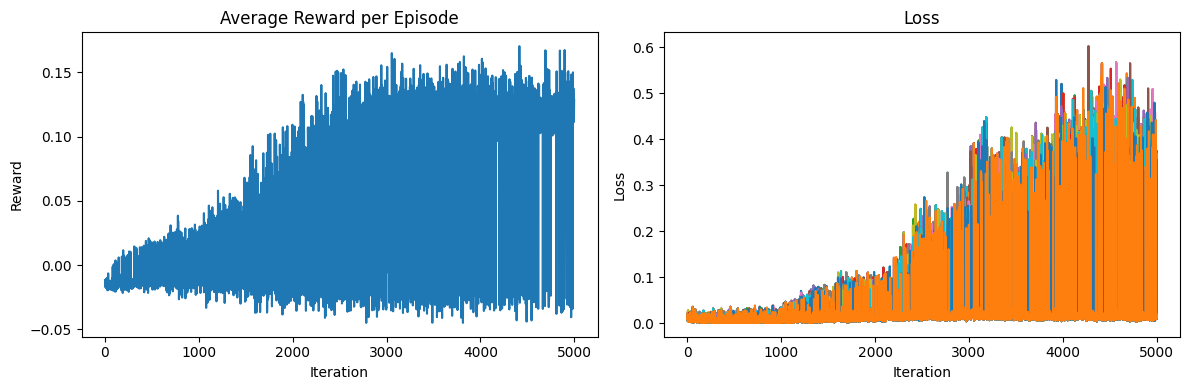

In [22]:
# Plot training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rewards_history)
plt.title('Average Reward per Episode')
plt.xlabel('Iteration')
plt.ylabel('Reward')

plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

 ### Random policy reward
 
Just a baseline (not the one you are supposed to develop)

In [23]:
random_env = get_env(100)
random_rewards = []

for _ in trange(1000):
    probs = tf.convert_to_tensor([[.25]*4]*random_env.n_boards)
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)
    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(np.mean(rewards))

100%|██████████| 1000/1000 [00:03<00:00, 275.82it/s]
